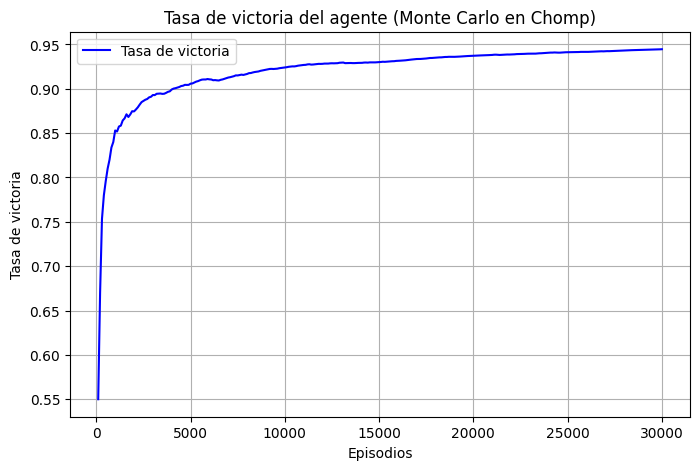

In [6]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# ----------------------------
# Parámetros del entorno
# ----------------------------
ROWS = 4       # m: filas
COLS = 6       # n: columnas
EPISODES = 30000
EPSILON_START = 1
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.99

# ----------------------------
# Funciones auxiliares
# ----------------------------
def get_possible_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(1, state[i] + 1):
            actions.append((i, j))
    return actions

def apply_action(state, action):
    i, j = action
    new_state = list(state)
    for k in range(i, len(state)):
        new_state[k] = min(new_state[k], j - 1)
    return tuple(new_state)

def is_terminal(state):
    return state == (1,) + (0,) * (len(state) - 1)

def choose_action(state, Q, epsilon):
    actions = get_possible_actions(state)
    if not actions:
        return None
    if random.random() < epsilon:
        return random.choice(actions)
    q_vals = [Q[(state, a)] for a in actions]
    max_q = max(q_vals)
    best_actions = [a for a, q in zip(actions, q_vals) if q == max_q]
    return random.choice(best_actions)

# ----------------------------
# Monte Carlo Entrenamiento
# ----------------------------
Q = defaultdict(float)
returns_count = defaultdict(int)
epsilon = EPSILON_START
win_counts = 0
win_rates = []

for episode in range(EPISODES):
    state = tuple([COLS] * ROWS)
    episode_history = []
    player_turn = random.randint(0, 1)
    reward = 0  # <- Inicializamos reward

    while not is_terminal(state):
        if player_turn == 0:
            action = choose_action(state, Q, epsilon)
            if action is None:
                reward = -1
                break
            episode_history.append((state, action))

            if action == (0, state[0]):  # se comió la onza envenenada
                reward = -1
                break

            new_state = apply_action(state, action)
            if is_terminal(new_state):
                reward = 1
                state = new_state
                break

            state = new_state
        else:
            actions = get_possible_actions(state)
            if not actions:
                reward = 1
                break
            action = random.choice(actions)
            if action == (0, state[0]):
                reward = 1  # el oponente pierde
                break
            new_state = apply_action(state, action)
            if is_terminal(new_state):
                reward = -1  # el oponente gana
                break
            state = new_state

        player_turn = 1 - player_turn

    # Monte Carlo update (first-visit)
    visited = set()
    for (s, a) in episode_history:
        if (s, a) in visited:
            continue
        visited.add((s, a))
        returns_count[(s, a)] += 1
        Q[(s, a)] += (reward - Q[(s, a)]) / returns_count[(s, a)]

    if reward == 1:
        win_counts += 1

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

    if (episode + 1) % 100 == 0:
        win_rates.append(win_counts / (episode + 1))

# ----------------------------
# Visualización
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(np.arange(100, EPISODES + 1, 100), win_rates, label='Tasa de victoria', color='blue')
plt.xlabel("Episodios")
plt.ylabel("Tasa de victoria")
plt.title("Tasa de victoria del agente (Monte Carlo en Chomp)")
plt.grid(True)
plt.legend()
plt.show()
